# Imports Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

# Loading Datasets

In [2]:
# LOading datasets train and test
def date_parser(date_str):
    return pd.to_datetime(date_str, format='%Y-%m-%d')

train_df = pd.read_csv("../demand-forecasting-kernels-only/train.csv",parse_dates=['date'], date_parser=date_parser)
test_df = pd.read_csv("../demand-forecasting-kernels-only/test.csv", index_col= 0,parse_dates=['date'], date_parser=date_parser)

In [3]:
print(train_df.shape)
train_df.head()

(913000, 4)


,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [4]:
print(test_df.shape)
test_df.head()

(45000, 3)


,date,store,item
id,,,
0,2018-01-01,1,1
1,2018-01-02,1,1
2,2018-01-03,1,1
3,2018-01-04,1,1
4,2018-01-05,1,1


In [5]:
print("===========Training dataset dtypes=================")
print(train_df.dtypes)
print("\n===========Testing dataset dtypes==================")
print(test_df.dtypes)

===========Training dataset dtypes=================
date     datetime64[ns]
store             int64
item              int64
sales             int64
dtype: object

===========Testing dataset dtypes==================
date     datetime64[ns]
store             int64
item              int64
dtype: object


In [6]:
# changing dtypes of date and sales

train_df = train_df.astype({"sales": "float64", "store": "category", "item": "category"})
test_df = test_df.astype({"store": "category", "item": "category"})

In [7]:
print("===========Training dataset dtypes=================")
print(train_df.dtypes)
print("\n===========Testing dataset dtypes==================")
print(test_df.dtypes)

===========Training dataset dtypes=================
date     datetime64[ns]
store          category
item           category
sales           float64
dtype: object

===========Testing dataset dtypes==================
date     datetime64[ns]
store          category
item           category
dtype: object


# Feature Enginering

In [8]:
def createAdditionalFeatures(df):

        df = df.copy()
        df["day"] = df.index.dayofweek
        df["quarter"] = df.index.quarter
        df['year'] = df.index.year
        df['month'] = df.index.month
        df['dayofyear'] = df.index.dayofyear
        df['dayofmonth'] = df.index.day
        df['weekofyear'] = df.index.isocalendar().week

        for lag in [91, 126, 364, 728, 1092]:
                df[f"lag_{lag}"] = df.groupby(["store", "item"])["sales"].transform(lambda x: x.shift(lag))
                
        return df

In [9]:
def convertToCategory(df):
    cols = ["day","quarter", "year", "month", "dayofyear", "dayofmonth", "weekofyear"]

    for col in cols:
        df = df.astype({col: "category"})
    
    return df

In [10]:
training_df = train_df.set_index("date")
training_df = createAdditionalFeatures(training_df)
training_df = convertToCategory(training_df)
print(training_df.shape)
training_df.tail()

(913000, 15)


,store,item,sales,day,quarter,year,month,dayofyear,dayofmonth,weekofyear,lag_91,lag_126,lag_364,lag_728,lag_1092
date,,,,,,,,,,,,,,,
2017-12-27,10,50,63.0,2,4,2017,12,361,27,52,80.0,104.0,43.0,51.0,40.0
2017-12-28,10,50,59.0,3,4,2017,12,362,28,52,82.0,89.0,68.0,44.0,46.0
2017-12-29,10,50,74.0,4,4,2017,12,363,29,52,90.0,98.0,63.0,59.0,53.0
2017-12-30,10,50,62.0,5,4,2017,12,364,30,52,103.0,92.0,64.0,63.0,61.0
2017-12-31,10,50,82.0,6,4,2017,12,365,31,52,99.0,116.0,69.0,81.0,57.0


# XGBoost Cross Validation

In [11]:
tss = TimeSeriesSplit(n_splits= 5, test_size= 24*365*10, gap= 24)
training_df = training_df.sort_index()

preds = []
scores = []

features = [col for col in training_df.columns if col not in ["sales"]]
target = "sales"

params = {
        'base_score': 0.5, 
        'booster': "gbtree",
        'n_estimators': 2000, 
        'early_stopping_rounds': 50,
        'learning_rate': 0.05,
        'enable_categorical': True,
        'tree_method': 'hist',
        'objective': 'reg:squarederror',
        'max_depth': 5,
        'subsample': 0.7,
        'colsample_bytree': 0.7,
        'alpha': 0.2,
        'lambda': 0.2,}

for index, (train_id, val_id) in enumerate(tss.split(training_df)):

    train = training_df.iloc[train_id]
    val = training_df.iloc[val_id]

    X_train = train[features]
    y_train = train[target]

    X_test = val[features]
    y_test = val[target]

    print(f"============================Fold {index}================================")
    reg = xgb.XGBRegressor(**params)

    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose= 200)
    
    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)
    print("\n")

============================Fold 0================================
[0]	validation_0-rmse:51.98276	validation_1-rmse:52.55411
[200]	validation_0-rmse:7.29443	validation_1-rmse:7.68052
[383]	validation_0-rmse:7.09284	validation_1-rmse:7.66877


============================Fold 1================================
[0]	validation_0-rmse:52.10075	validation_1-rmse:63.56717
[200]	validation_0-rmse:7.33763	validation_1-rmse:8.91087
[287]	validation_0-rmse:7.22556	validation_1-rmse:8.90637


============================Fold 2================================
[0]	validation_0-rmse:53.78077	validation_1-rmse:59.42134
[200]	validation_0-rmse:7.49526	validation_1-rmse:8.55145
[207]	validation_0-rmse:7.48410	validation_1-rmse:8.55193


============================Fold 3================================
[0]	validation_0-rmse:54.48542	validation_1-rmse:62.80932
[200]	validation_0-rmse:7.58511	validation_1-rmse:8.45260
[400]	validation_0-rmse:7.35678	validation_1-rmse:8.33744
[549]	validation_0-rmse:7.2460

In [12]:
print(f"Fold Scores: {scores}")
print(f"Average Score: {np.mean(scores):0.2f}")

Fold Scores: [7.745017035840021, 8.89851387638874, 8.362275654482245, 8.32446340868113, 8.665090292733579]
Average Score: 8.40


# Retraining XGBoost Model and Predict the Future

In [13]:
# Retrain using all data for predicting future 
training_df = training_df.sort_values(["store","item"], ascending=[True, True])
X_all = training_df[features]
y_all =training_df[target]

params = {
        'base_score': 0.5, 
        'booster': "gbtree",
        'n_estimators': 2000, 
        'early_stopping_rounds': 50,
        'learning_rate': 0.05,
        'enable_categorical': True,
        'tree_method': 'hist',
        'objective': 'reg:squarederror',
        'max_depth': 5,
        'subsample': 0.7,
        'colsample_bytree': 0.7,
        'alpha': 0.2,
        'lambda': 0.2,}

reg = xgb.XGBRegressor(**params,)

reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all),],
        verbose= 200)

[0]	validation_0-rmse:56.39909
[200]	validation_0-rmse:7.75427
[400]	validation_0-rmse:7.52804
[600]	validation_0-rmse:7.38833
[800]	validation_0-rmse:7.29440
[1000]	validation_0-rmse:7.22176
[1200]	validation_0-rmse:7.16563
[1400]	validation_0-rmse:7.11888
[1600]	validation_0-rmse:7.07965
[1800]	validation_0-rmse:7.04540
[1999]	validation_0-rmse:7.01546


XGBRegressor(alpha=0.2, base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, early_stopping_rounds=50,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=0.2, learning_rate=0.05,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=2000, n_jobs=None, num_parallel_tree=None, ...)

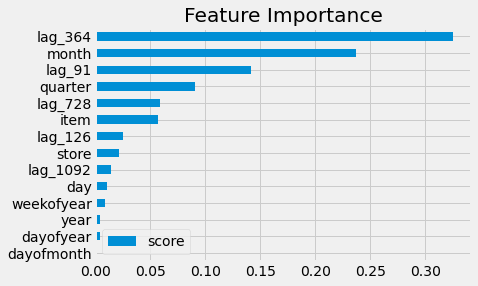

In [14]:
feature_importance = pd.DataFrame(data=reg.feature_importances_,
                                  index=reg.feature_names_in_,
                                  columns= ["score"])

feature_importance.sort_values('score').plot(kind= "barh", title= "Feature Importance")
plt.show()

In [15]:
test_df = test_df.set_index("date")
df = pd.concat([training_df, test_df])
df = createAdditionalFeatures(df)
df = convertToCategory(df)
print(df.shape)
df.tail()

(958000, 15)


,store,item,sales,day,quarter,year,month,dayofyear,dayofmonth,weekofyear,lag_91,lag_126,lag_364,lag_728,lag_1092
date,,,,,,,,,,,,,,,
2018-03-27,10,50,NaN,1,1,2018,3,86,27,13,41.0,81.0,60.0,73.0,61.0
2018-03-28,10,50,NaN,2,1,2018,3,87,28,13,63.0,81.0,73.0,68.0,61.0
2018-03-29,10,50,NaN,3,1,2018,3,88,29,13,59.0,87.0,68.0,75.0,77.0
2018-03-30,10,50,NaN,4,1,2018,3,89,30,13,74.0,81.0,69.0,83.0,79.0
2018-03-31,10,50,NaN,5,1,2018,3,90,31,13,62.0,78.0,101.0,82.0,81.0


In [16]:
future_df = df.loc[df.sales.isna()].copy()
future_df["pred"] = reg.predict(future_df[features])
print(future_df.shape)
future_df.head()

(45000, 16)


,store,item,sales,day,quarter,year,month,dayofyear,dayofmonth,weekofyear,lag_91,lag_126,lag_364,lag_728,lag_1092,pred
date,,,,,,,,,,,,,,,,
2018-01-01,1,1,NaN,0,1,2018,1,1,1,1,12.0,15.0,15.0,12.0,14.0,13.327691
2018-01-02,1,1,NaN,1,1,2018,1,2,2,1,18.0,21.0,10.0,12.0,9.0,13.283091
2018-01-03,1,1,NaN,2,1,2018,1,3,3,1,15.0,22.0,16.0,16.0,13.0,15.016582
2018-01-04,1,1,NaN,3,1,2018,1,4,4,1,20.0,26.0,14.0,12.0,18.0,15.312270
2018-01-05,1,1,NaN,4,1,2018,1,5,5,1,19.0,38.0,24.0,12.0,18.0,17.207396


In [17]:
future_df.tail()

,store,item,sales,day,quarter,year,month,dayofyear,dayofmonth,weekofyear,lag_91,lag_126,lag_364,lag_728,lag_1092,pred
date,,,,,,,,,,,,,,,,
2018-03-27,10,50,NaN,1,1,2018,3,86,27,13,41.0,81.0,60.0,73.0,61.0,70.679657
2018-03-28,10,50,NaN,2,1,2018,3,87,28,13,63.0,81.0,73.0,68.0,61.0,72.369370
2018-03-29,10,50,NaN,3,1,2018,3,88,29,13,59.0,87.0,68.0,75.0,77.0,76.408539
2018-03-30,10,50,NaN,4,1,2018,3,89,30,13,74.0,81.0,69.0,83.0,79.0,80.296875
2018-03-31,10,50,NaN,5,1,2018,3,90,31,13,62.0,78.0,101.0,82.0,81.0,83.752960


# Forecasting Total Sales

In [18]:
pred_total_sales_df = future_df.reset_index()[["date","pred"]].set_index("date").rename(columns= {"pred":"sales"})

year_month = pred_total_sales_df.index.to_period("M")

pred_total_sales_df = pred_total_sales_df.groupby(year_month).agg({"sales": ["count","sum", "mean", "median", "std", "min", "max"]})
print(pred_total_sales_df.shape)
pred_total_sales_df.head()

(3, 7)


sales                                                           \
         count          sum       mean     median        std        min   
date                                                                      
2018-01  15500  629424.1875  40.608013  38.045692  19.618302   7.850251   
2018-02  14000  640429.4375  45.744961  43.081753  22.135575   7.579201   
2018-03  15500  851943.3750  54.964088  51.833138  26.424812  10.223233   

                     
                max  
date                 
2018-01  110.047379  
2018-02  124.667557  
2018-03  144.651672

In [19]:
total_sales_df = train_df.drop(columns = ["store", "item"]).set_index("date")

year_month = total_sales_df.index.to_period("M")
total_sales_df = total_sales_df.groupby(year_month).agg({"sales": ["count","sum", "mean", "median", "std", "min", "max"]})
total_sales_df = pd.concat([total_sales_df,pred_total_sales_df])
total_sales_df.drop(total_sales_df.tail(2).index,
                    inplace = True)
print(total_sales_df.shape)
total_sales_df.head()

(61, 7)


sales                                                   
         count       sum       mean median        std  min    max
date                                                             
2013-01  15500  454904.0  29.348645   27.0  15.087507  2.0   97.0
2013-02  14000  459417.0  32.815500   30.0  16.824119  2.0  103.0
2013-03  15500  617382.0  39.831097   37.0  20.167826  3.0  122.0
2013-04  15000  682274.0  45.484933   42.0  22.898429  3.0  138.0
2013-05  15500  763242.0  49.241419   46.0  24.630070  3.0  156.0

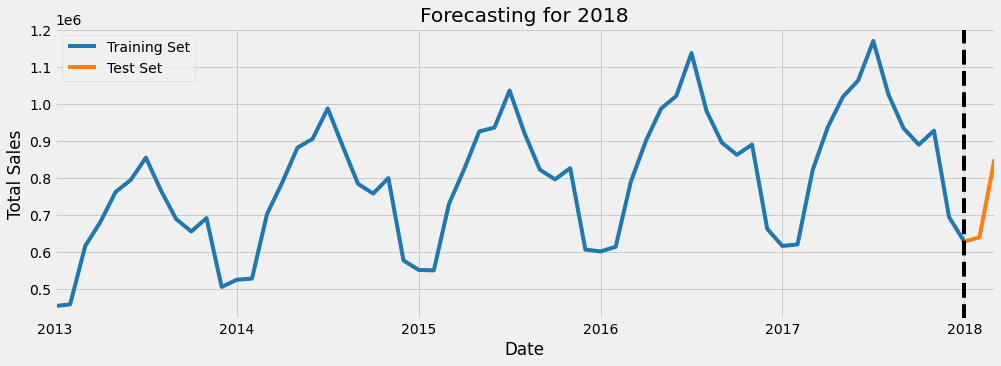

In [20]:
fig, ax = plt.subplots(figsize=(15,5))
total_sales_df[("sales","sum")].plot(ax= ax,
                    label= "Training Set",
                    title= "Forecasting for 2018", 
                    color= color_pal[0],)
pred_total_sales_df[("sales","sum")].plot(ax= ax,
                    label= "Test Set",
                    color= color_pal[1])
ax.axvline(pred_total_sales_df.index.min(), color= "black", ls= "--")
ax.set(xlabel='Date', ylabel='Total Sales')
ax.legend(["Training Set","Test Set",])
plt.show()

# Predicted 2018 Daily Sales

In [21]:
daily_df = future_df.groupby(["date"]).agg({"pred": ["count","sum", "mean", "median", "std", "min", "max"]})
print(daily_df.shape)
daily_df.head()

(90, 7)


pred                                                            \
           count           sum       mean     median        std        min   
date                                                                         
2018-01-01   500  16483.398438  32.966797  30.794765  15.248979   7.906031   
2018-01-02   500  18652.371094  37.304741  35.166145  17.503498   9.511496   
2018-01-03   500  19349.066406  38.698132  36.725517  17.900120   9.572255   
2018-01-04   500  20321.410156  40.642818  38.244751  19.014750   9.970961   
2018-01-05   500  21605.900391  43.211800  40.693138  20.090891  10.274643   

                       
                  max  
date                   
2018-01-01  69.893059  
2018-01-02  82.126900  
2018-01-03  84.899399  
2018-01-04  94.599998  
2018-01-05  94.370956

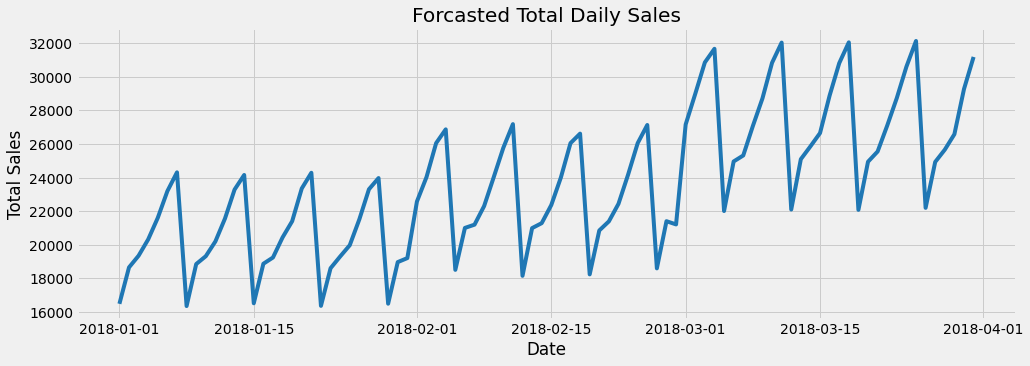

In [22]:
# Daily sales in 2018 for all stores
plt.figure(figsize=(15,5))

ax = sns.lineplot(data= daily_df,x='date',y=('pred','sum'),color= color_pal[0])
ax.set(xlabel='Date', ylabel='Total Sales', title='Forcasted Total Daily Sales')
plt.show()

## Output to CSV

In [23]:
output_df = pd.DataFrame(future_df["pred"]).rename(columns={"pred":"sales"}).reset_index(drop=True).rename_axis('id', axis=1)
print(output_df.shape)
output_df.head()

(45000, 1)


id,sales
0,13.327691
1,13.283091
2,15.016582
3,15.312270
4,17.207396


In [24]:
output_df.to_csv("../results/xgboost_submission.csv", index=True, index_label= "id")